**Authors:**  Kleanthis Karamvasis <br>
**Copyright:** 2024 Kleanthis Karamvasis <br>
**License:** GPLv3

<div class="alert alert-block alert-success">
<h3>FLOODPY: Delineating flooded regions of Daniel Flood event Greece, September 2023 </h3></div>

<div class="alert alert-block alert-warning">

### Important:
<font size="3"> Before running this notebook, please make sure that 
- you have a <b>CUDA compatible GPU</b>
- you have successufully <b>created</b> floodpy_gpu conda environment based on [FLOODPY_gpu_env](FLOODPY_gpu_env.yml)
- you have <b>activated</b> the floodpy_gpu conda environment for running this notebook 
- you have downloaded Floodvit model from https://www.dropbox.com/scl/fi/srw7u4cw1gtxrf4xzmsh7/floodvit.pt?rlkey=snskpq1qrdav5u2jya8k2bocg&e=1&dl=0
</font>
</div>

# NOTEBOOK INTRODUCTION

### Data used

| Product Name | Description | Usage | Access Link |
|:--------------------:|:-----------------:|:-----------------:|:-----------------:|
| ERA5 | ERA5 is the fifth generation ECMWF reanalysis for the global climate and weather for the past 4 to 7 decades. ERA5 provides hourly estimates for a large number of atmospheric, ocean-wave and land-surface quantities. Data has been regridded to a regular lat-lon grid of 0.25 degrees for the reanalysis. ERA5 is updated daily with a latency of about 5 days. | Precipitation | <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels" target="_blank">link</a> |
| Sentinel-1 GRD | The Sentinel-1 mission comprises a constellation of two polar-orbiting satellites, operating day and night performing C-band synthetic aperture radar imaging, enabling them to acquire imagery regardless of the weather. | Backscatter changes | <a href="https://dataspace.copernicus.eu/" target="_blank">link</a> |

### Learning outcomes

At the end of this notebook you will be able to identify flooded regions from Sentinel-1 data using FloodPy. Be aware that the estimated run time of the notebook depends on your **area of interest**, your **temporal span of interest** and your network **download speed**.

### Outline
<font size="3">
Floods are considered the second gravest disaster for the agricultural sector. The increasing intensity and the frequency of flood events can result to significant yield losses. In the present notebook, we present a <b>ViT-based (Visual Transformer) approach</b> (Bountos et al., 2023) to extract flooded area based on multitemporal Sentinel-1 intensity observations.
<br>
    
The FLOODPY - <b>FLOOD PYthon toolbox</b> is a free and open-source python toolbox for mapping of floodwater. FLOODPY requires a specified time of interest related to the flood event and corresponding geographical boundaries. We believe that the produced maps with delineated flood-affected agricultural fields can be helpful for governments, insurers and disaster response agencies to improve flood risk assessment, relief targeting, and ultimately to protect climate-vulnerable communities from floods. 

References:

<font size="2">
    
Bountos, N. I., Sdraka, M., Zavras, A., Karasante, I., Karavias, A., Herekakis, T., ... & Papoutsis, I. (2023). Kuro Siwo: 12.1 billion $ m^ 2$ under the water. A global multi-temporal satellite dataset for rapid flood mapping. arXiv preprint [paper link](https://arxiv.org/abs/2311.12056) [github link](https://github.com/Orion-AI-Lab/KuroSiwo)


<div class="alert alert-info" role="alert">
    
## <a id='TOC_TOP'></a>Contents

</div>
    
[1. Flood event description](#section1)

[2. Set input arguments for FLOODPY](#section2)

[3. Estimation of Flooded Area](#section3)

[4. Interactive Plotting](#section4)

<hr>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Flood event description
[Back to top](#TOC_TOP)

</div>


In September 2023 large areas in the Mediterranean were affected by Storm Daniel. On 5-7 September 2023 Thessaly experienced extreme rainfall followed by extensive floods, resulting in the loss of human lives, livestock, harvests, land and assets. The flooding was a sudden-onset event as the floods occurred very fast.

More information: https://european-flood.emergency.copernicus.eu/en/news/storm-daniel-affects-greece-bulgaria-and-turkiye-september-2023 



<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Set input parameters for FLOODPY
[Back to top](#TOC_TOP)

</div>


In [1]:
# The path of your project. Make sure you have enough free space disk on the specific location.
projectfolder = '/home/kleanthis/Projects/Thessalia_Floods_2023'

# The location of floodpy code 
src_dir = '/home/kleanthis/Projects/FLOODPY/floodpy/'

# SNAP ORBIT DIRECTORY
snap_orbit_dir = '/home/kleanthis/.snap/auxdata/Orbits/Sentinel-1'

# SNAP GPT full path
GPTBIN_PATH = '/home/kleanthis/snap9/bin/gpt'

# The start and end datetimes for Pre-flood time span and flood time span (Format is YYYYMMDDTHHMMSS in UTC)
pre_flood_start = '20230701T030000'
pre_flood_end = '20230903T030000'
flood_start = '20230903T030000'
flood_end = '20230909T030000'

# Flood event spatial information 
# - You can provide AOI VECTOR FILE or AOI BBOX. 
# - Please ensure that your AOI BBOX has dimensions smaller than 100km x 100km
# - If you provide AOI VECTOR, AOI BBOX parameters will be ommited
# - In case you provide AOI BBOX coordinates, set  AOI_File = None

# AOI VECTOR FILE (if given AOI BBOX parameters can be ommited)
AOI_File = "None"

# AOI BBOX (WGS84)
LONMIN = 21.82
LATMIN = 39.35
LONMAX = 22.30
LATMAX = 39.65

# Data access and processing
# The number of Sentinel-1 relative orbit. The default 
#       value is Auto. Auto means that the relative orbit that has
#       the Sentinel-1 image closer to the Flood_datetime is selected. 
#       S1_type can be GRD or SLC.
relOrbit = 'Auto' 

# The minimum mapping unit area in square meters
minimum_mapping_unit_area_m2=4000

# Computing resources to employ
CPU=8
RAM='20G'

# Credentials for Sentinel-1/2 downloading
Copernicus_username = 'Floodmappingteam@gmail.com'
Copernicus_password = '!!2024Floodpy'

<div class="alert alert-block alert-warning">

#### Important: <font size="3"> Please provide the path of the Floodvit model [link](https://www.dropbox.com/scl/fi/srw7u4cw1gtxrf4xzmsh7/floodvit.pt?rlkey=snskpq1qrdav5u2jya8k2bocg&e=1&dl=0)</font></div>

In [ ]:
ViT_model_filename = '/home/kleanthis/Projects/Thessalia_Floods_2023/Vit_model/floodvit.pt'

In [2]:
params_dict = {'projectfolder':projectfolder,
            'src_dir' : src_dir,
            'snap_orbit_dir' : snap_orbit_dir,
            'GPTBIN_PATH' : GPTBIN_PATH,
            'pre_flood_start' : pre_flood_start,
            'pre_flood_end' : pre_flood_end,
            'flood_start' : flood_start,
            'flood_end' : flood_end,
            'AOI_File' : AOI_File,
            'LONMIN' : LONMIN,
            'LATMIN' : LATMIN,
            'LONMAX' : LONMAX,
            'LATMAX' : LATMAX,
            'relOrbit' : relOrbit,
            'minimum_mapping_unit_area_m2' : minimum_mapping_unit_area_m2,
            'CPU' : CPU,
            'RAM' : RAM,
            'Copernicus_username' : Copernicus_username,
            'Copernicus_password' : Copernicus_password,
            }

<div class="alert alert-info" role="alert">

## <a id='section2'></a>3. Estimation of Flooded Area using Sentinel-1 data
[Back to top](#TOC_TOP)
</div>

### <a id='search_download'></a> Insert Python Modules

In [3]:
import os
import numpy as np
import rasterio as rio
import rasterio.mask
import geopandas as gpd
import pandas as pd
import xarray as xr

# plotting functionalities
import matplotlib.pyplot as plt
import folium
import matplotlib
from branca.element import Template, MacroElement
import branca.colormap as cm
from folium.plugins import MeasureControl, Draw
from xyzservices.lib import TileProvider

# FLOODPY libraries
from floodpy.utils.folium_categorical_legend import get_folium_categorical_template
from floodpy.FLOODPYapp import FloodwaterEstimation


### <a id='search_download'></a> Start up

In [4]:
Floodpy_app = FloodwaterEstimation(params_dict = params_dict)

### Donwload Landcover

In [5]:
Floodpy_app.download_landcover_data()

### <a id='search_download'></a> Downloading Precipitation from ERA5 model


Based on given temporal range, ERA5 dataset is retrieved for 20 days before the flood event and 3 dates after the flood event. The defined area of interest is used to spatially subset the dataset.

In [6]:
Floodpy_app.download_ERA5_Precipitation_data()

Precipitation data can be found at /home/kleanthis/Projects/Thessalia_Floods_2023/ERA5


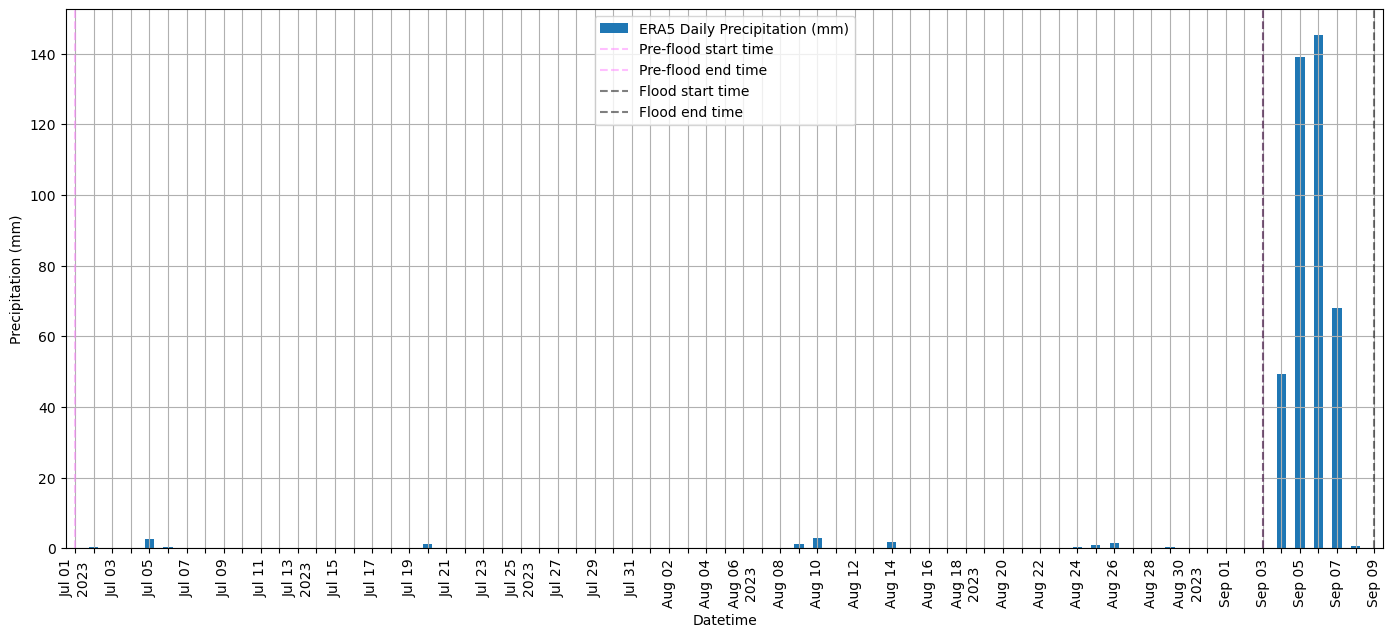

In [7]:
Floodpy_app.plot_ERA5_precipitation_data()

In [8]:
Floodpy_app.query_S1_data()
print('The available dates for flood mapping are: \n --> {}'.format('\n --> '.join(map(str, Floodpy_app.flood_candidate_dates))))

The available dates for flood mapping are: 
 --> 2023-09-06T04:39:47.095652000
 --> 2023-09-06T04:40:12.094690000
 --> 2023-09-07T16:24:12.139701000
 --> 2023-09-07T16:24:37.139651000


<div class="alert alert-block alert-warning">

#### Important: <font size="3"> Please select ONE of the availables dates for flood mapping</font></div>

In [9]:
sel_flood_date = '2023-09-06T04:39:47.096000000'

In [10]:
Floodpy_app.sel_S1_data(sel_flood_date)

Please select one of the available dates for flood mapping: ['2023-09-06T04:39:47.095652000' '2023-09-06T04:40:12.094690000'
 '2023-09-07T16:24:12.139701000' '2023-09-07T16:24:37.139651000']


In [11]:
Floodpy_app.download_S1_GRD_products()

Creating token for downloading Copernicus products


In [12]:
Floodpy_app.download_S1_orbits()

### <a id='search_download'></a> Preprocessing of multitemporal Sentinel-1 data

Preprocessing of Sentinel-1 SAR acquisitions consists of the following steps:
- Orbit correction
- Coregistration
- Subsetting
- Radiometric Calibration
- Geocoding

In [13]:
Floodpy_app.create_S1_stack(overwrite=False)

In [14]:
S1_stack = xr.open_dataset(Floodpy_app.S1_stack_filename)
#S1_stack['VV_dB'].drop_duplicates(dim=...).plot(x="x", y="y", col="time", col_wrap=3, vmin=-22, vmax=5)

### Calculate Elevation slope and mask

In [15]:
Floodpy_app.calc_slope()
DEM_slope_stack = xr.open_dataset(Floodpy_app.DEM_slope_filename)
# DEM_slope_stack['DEM'].plot()
# DEM_slope_stack['slope'].plot()
# DEM_slope_stack['slope_mask'].plot()

In [16]:
Floodpy_app.calc_flooded_regions_ViT(ViT_model_filename = ViT_model_filename)

Predictions with starting point: 0 pixel


100%|██████████| 400/400 [00:22<00:00, 17.95it/s]


Predictions with starting point: 56 pixel


100%|██████████| 375/375 [00:19<00:00, 19.09it/s]


Predictions with starting point: 112 pixel


100%|██████████| 375/375 [00:19<00:00, 18.85it/s]


Predictions with starting point: 168 pixel


100%|██████████| 360/360 [00:18<00:00, 19.04it/s]


In [ ]:
# Read AOI
aoi = gpd.read_file(Floodpy_app.geojson_bbox)

# AOI bounds
left, bottom, right, top = aoi.total_bounds

# Define map bounds
map_bounds = [[bottom, left], [top, right]]

# Create a map located to the AOI
m = folium.Map(location=[aoi.centroid.y[0], aoi.centroid.x[0]], tiles="openstreetmap", zoom_start=13)

folium.TileLayer("openstreetmap").add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)

# measuring funcs
MeasureControl('bottomleft').add_to(m)

# drawing funcs
draw = Draw(export = True,
            filename=os.path.join(projectfolder,'myJson.json'),
            position='topleft').add_to(m)

# add geojson AOI
folium.GeoJson(aoi["geometry"],
               show = False,
               name='Area of Interest').add_to(m)

#------------------------------------------------------------------------------
# ESA worldcover 

with rio.open(Floodpy_app.lc_mosaic_filename) as src:
    LC_cover, out_transform = rasterio.mask.mask(src, aoi.geometry, crop=True)
    LC_cover = LC_cover[0,:,:]

LC_map = folium.raster_layers.ImageOverlay(image = LC_cover,
                                        name = 'ESA Worldcover 2021',
                                        opacity = 1,
                                        bounds = map_bounds,
                                        show = False,
                                        colormap = lambda x: Floodpy_app.LC_COLORBAR[x])

m.add_child(LC_map)

legend_categories = {Floodpy_app.LC_CATEGORIES[x]: Floodpy_app.LC_COLORBAR[x] for x in np.unique(LC_cover)}

template = get_folium_categorical_template(legend_categories)
macro = MacroElement()
macro._template = Template(template)
m.get_root().add_child(macro)

#------------------------------------------------------------------------------
# S1 VV backscatter Flood image

S1_stack_dB = xr.open_dataset(Floodpy_app.S1_stack_filename)['VV_dB']
Flood_data = S1_stack_dB.sel(time = pd.to_datetime(Floodpy_app.flood_datetime_str)).values

vmin = np.nanquantile(Flood_data, 0.01)
vmax = np.nanquantile(Flood_data, 0.99)

S1_data = np.clip(Flood_data, vmin, vmax)

cmap = cm.LinearColormap(['black', 'white'],
                            index=[vmin, vmax],
                            vmin=vmin, vmax=vmax)

cmap.caption = "Backscatter coefficient VV (dB)"
cmap_func = lambda x: matplotlib.colors.to_rgba(cmap(x)) if ~np.isnan(x) else (0,0,0,0)

folium.raster_layers.ImageOverlay(image = S1_data,
                                  name = "Sentinel-1 ({})".format(Floodpy_app.flood_datetime_str),
                                  opacity = 1,
                                  bounds = map_bounds,
                                  colormap = cmap_func).add_to(m)
m.add_child(cmap)

#------------------------------------------------------------------------------
# Flood binary mask

Flood_map_dataset = xr.open_dataset(Floodpy_app.Flood_map_dataset_filename)
flooded_regions = Flood_map_dataset.flooded_regions.data.astype(np.int32)

raster_to_coloridx = {1: (0.0, 0.0, 1.0, 0.8),
                      0: (0.0, 0.0, 0.0, 0.0)}

m.add_child(folium.raster_layers.ImageOverlay(image = flooded_regions, 
                                             name = 'Flooded Regions {} (UTC)'.format(Floodpy_app.flood_datetime_str),
                                             bounds = map_bounds,
                                             colormap = lambda x: raster_to_coloridx[x]))

folium.LayerControl('bottomleft', collapsed=False).add_to(m)

m